<a href="https://colab.research.google.com/github/Kryptera-K/SPY-Hull-Heartbeat-Strategy/blob/main/SPY_D1_%5B'HMA_Fast_Rising'%5D%5B'QQE_Value1_CrossAbove_Level'%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "SPY"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("SPY_clean.csv", index=False)
df

/tmp/ipython-input-2179006733.py:15: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2000-01-03,91.887794,93.664739,90.900603,93.664739,8164300
2000-01-04,88.294373,91.019020,88.225269,90.683375,8089800
2000-01-05,88.452370,89.419817,86.714912,88.412882,12177900
2000-01-06,87.030746,89.400005,87.030746,88.215375,6227200
2000-01-07,92.085205,92.085205,88.491829,88.649779,8066500
...,...,...,...,...,...
2025-09-25,658.049988,659.409973,654.409973,657.940002,89622100
2025-09-26,661.820007,662.369995,657.880005,659.510010,69179200
2025-09-29,663.679993,665.280029,661.859985,664.359985,73499000


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

HMA_FAST_LENGTH = 20
HMA_SLOW_LENGTH = 50
QQE_FACTOR = 4.236
QQE_LEVEL = 50
QQE_PERIOD = 14
QQE_SMOOTH = 5

# -------------------------
# Indicator Functions
# -------------------------

def hma_fast_rising(df, fast_length=HMA_FAST_LENGTH, slow_length=HMA_SLOW_LENGTH):
    df = calculate_hma(df, fast_length, slow_length)
    return df['HMA_Fast'].diff() > 0


def calculate_hma(df, fast_length=HMA_FAST_LENGTH, slow_length=HMA_SLOW_LENGTH):
    df = df.copy()
    df['HMA_Fast'] = hull_moving_average(df['Close'], fast_length)
    df['HMA_Slow'] = hull_moving_average(df['Close'], slow_length)
    return df


def hull_moving_average(series, length):
    """Calculate Hull Moving Average (HMA)"""
    half_length = int(length / 2)
    sqrt_length = int(np.sqrt(length))

    wma_half = series.rolling(window=half_length).mean()  # WMA approximation with SMA
    wma_full = series.rolling(window=length).mean()
    diff = 2 * wma_half - wma_full
    hma = diff.rolling(window=sqrt_length).mean()  # Final smoothing

    return hma


def qqe_cross_above_level(df, level=QQE_LEVEL):
    df = calculate_qqe(df)
    return (df['QQE_Value1'] > level) & (df['QQE_Value1'].shift(1) <= level)


def calculate_qqe(df, rsi_period=QQE_PERIOD, smooth=QQE_SMOOTH, factor=QQE_FACTOR):
    """
    Calculate QQE lines (Value1 & Value2) based on RSI smoothing and ATR-like smoothing.
    """
    df = df.copy()

    # --- RSI ---
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(alpha=1/rsi_period, adjust=False).mean()
    roll_down = down.ewm(alpha=1/rsi_period, adjust=False).mean()
    rsi = 100 - (100 / (1 + roll_up / roll_down))

    # --- Smoothed RSI ---
    rsi_ma = rsi.rolling(window=smooth).mean().fillna(method='bfill')

    # --- RSI Delta & ATR-like smoothing ---
    rsi_delta = rsi_ma.diff().abs().fillna(0)
    atr_rsi = rsi_delta.ewm(alpha=1/smooth, adjust=False).mean()

    # --- QQE Calculation ---
    value1 = rsi_ma.copy()
    value2 = pd.Series(index=df.index, dtype=float)
    value2.iloc[0] = value1.iloc[0]

    for i in range(1, len(df)):
        prev_trail = value2.iloc[i-1]
        prev_value1 = value1.iloc[i-1]
        atr = atr_rsi.iloc[i]
        direction = 1 if prev_value1 > prev_trail else -1
        value2.iloc[i] = prev_trail + direction * factor * atr

    df['QQE_Value1'] = value1
    df['QQE_Value2'] = value2

    return df



# -------------------------
# Entry conditions
# -------------------------

df["HMA_Fast_Rising"] = hma_fast_rising(df)

# -------------------------
# Exit conditions
# -------------------------

df["QQE_Value1_CrossAbove_Level"] = qqe_cross_above_level(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'HMA_Fast_Rising',
]
exit_conditions = [
    'QQE_Value1_CrossAbove_Level',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

/tmp/ipython-input-2570220582.py:62: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Start                                 2000-01-03 00:00:00
End                                   2025-10-01 00:00:00
Period                                 6476 days 00:00:00
Start Value                                      100000.0
End Value                                   990372.825306
Total Return [%]                               890.372825
Benchmark Return [%]                           608.025226
Max Gross Exposure [%]                              100.0
Total Fees Paid                              25291.797629
Max Drawdown [%]                                48.588748
Max Drawdown Duration                  1667 days 00:00:00
Total Trades                                           58
Total Closed Trades                                    57
Total Open Trades                                       1
Open Trade PnL                              116233.196191
Win Rate [%]                                    73.684211
Best Trade [%]                                  55.458036
Worst Trade [%

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2000-01-03 00:00:00
End                           2025-10-01 00:00:00
Period                         6476 days 00:00:00
Start Value                              100000.0
End Value                           708025.226235
Total Return [%]                       608.025226
Benchmark Return [%]                   608.025226
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        55.422902
Max Drawdown Duration          1554 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                      608025.226235
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-2230418026.py:16: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2230418026.py:64: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/tmp/ipython-input-2230418026.py:64: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



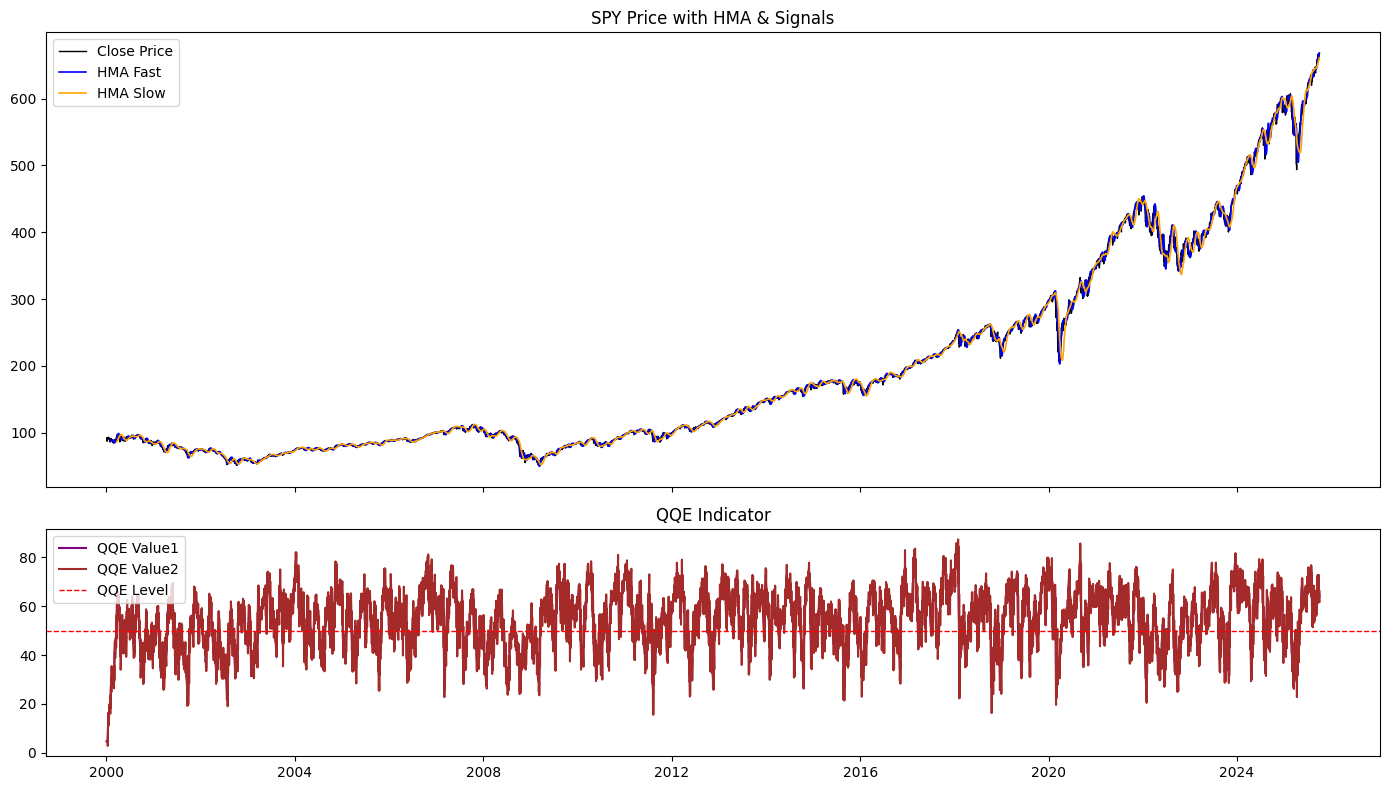

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# -------------------------
# Download Data
# -------------------------

symbol = "SPY"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)

# -------------------------
# Parameters
# -------------------------
HMA_FAST_LENGTH = 20
HMA_SLOW_LENGTH = 50
QQE_FACTOR = 4.236
QQE_LEVEL = 50
QQE_PERIOD = 14
QQE_SHIFT = 5
QQE_SMOOTH = 5

# -------------------------
# Indicator Functions
# -------------------------
def hull_moving_average(series, length):
    half_length = int(length / 2)
    sqrt_length = int(np.sqrt(length))

    wma_half = series.rolling(window=half_length).mean()
    wma_full = series.rolling(window=length).mean()
    diff = 2 * wma_half - wma_full
    hma = diff.rolling(window=sqrt_length).mean()

    return hma

def calculate_hma(df, fast_length=HMA_FAST_LENGTH, slow_length=HMA_SLOW_LENGTH):
    df['HMA_Fast'] = hull_moving_average(df['Close'], fast_length)
    df['HMA_Slow'] = hull_moving_average(df['Close'], slow_length)
    return df

def hma_fast_rising(df, fast_length=HMA_FAST_LENGTH, slow_length=HMA_SLOW_LENGTH):
    df = calculate_hma(df, fast_length, slow_length)
    return df['HMA_Fast'].diff() > 0

def calculate_qqe(df, rsi_period=QQE_PERIOD, smooth=QQE_SMOOTH, factor=QQE_FACTOR):
    df = df.copy()

    # RSI
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(alpha=1/rsi_period, adjust=False).mean()
    roll_down = down.ewm(alpha=1/rsi_period, adjust=False).mean()
    rsi = 100 - (100 / (1 + roll_up / roll_down))

    # Smoothed RSI
    rsi_ma = rsi.rolling(window=smooth).mean().fillna(method='bfill')

    # RSI Delta & ATR-like smoothing
    rsi_delta = rsi_ma.diff().abs().fillna(0)
    atr_rsi = rsi_delta.ewm(alpha=1/smooth, adjust=False).mean()

    # QQE Lines
    value1 = rsi_ma.copy()
    value2 = pd.Series(index=df.index, dtype=float)
    value2.iloc[0] = value1.iloc[0]

    for i in range(1, len(df)):
        prev_trail = value2.iloc[i-1]
        prev_value1 = value1.iloc[i-1]
        atr = atr_rsi.iloc[i]
        direction = 1 if prev_value1 > prev_trail else -1
        value2.iloc[i] = prev_trail + direction * factor * atr

    df['QQE_Value1'] = value1
    df['QQE_Value2'] = value2
    return df

def qqe_cross_above_level(df, level=QQE_LEVEL):
    df = calculate_qqe(df)
    return (df['QQE_Value1'] > level) & (df['QQE_Value1'].shift(1) <= level)

# -------------------------
# Apply Indicators
# -------------------------
df["HMA_Fast_Rising"] = hma_fast_rising(df)
df = calculate_qqe(df)
df["QQE_Value1_CrossAbove_Level"] = qqe_cross_above_level(df)

# Entry / Exit Signals
df['entry_signal'] = df["HMA_Fast_Rising"]
df['exit_signal']  = df["QQE_Value1_CrossAbove_Level"]

# -------------------------
# Plot
# -------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True,
                               gridspec_kw={'height_ratios':[2,1]})

# --- Price & HMA ---
ax1.plot(df.index, df['Close'], label='Close Price', color='black', linewidth=1)
ax1.plot(df.index, df['HMA_Fast'], label='HMA Fast', color='blue', linewidth=1.2)
ax1.plot(df.index, df['HMA_Slow'], label='HMA Slow', color='orange', linewidth=1.2)

ax1.set_title(f"{symbol} Price with HMA & Signals")
ax1.legend(loc='upper left')

# --- QQE ---
ax2.plot(df.index, df['QQE_Value1'], label='QQE Value1', color='purple')
ax2.plot(df.index, df['QQE_Value2'], label='QQE Value2', color='brown')
ax2.axhline(QQE_LEVEL, color='red', linestyle='--', linewidth=1, label='QQE Level')

ax2.set_title("QQE Indicator")
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()
